# What is this?
This Jupyter notebook contains Python code to build an LSTM recursive network that provides around 87-88% accuracy on the IMDB Movie Review Sentiment Analysis Dataset.

## ❗ ❗ ❗Exercise
You should try to repeat the training of the network by changing the parameters of the model. Try changing the revision size (set to 500) and the number of neurons in the LSTM or GRU (set to 32). You can also try increasing the number of epochs.

The objective is to improve the results obtained in the test set.

#Designed for Google Collaboratory
The code is ready to work in Google Collab. If you want to run it locally, you will have to configure all the elements (Cuda, Tensorflow...).

In Google Collab, to get the network to train faster we should use the GPU. In the Runtime menu, choose Change Runtime Type and select "GPU."

Do not forget to make the changes effective by clicking on Restart execution environment.

#Preparing everything
When running this code, you may receive a warning asking you to restart the Runtime Environment. You can ignore it or restart it with "Runtime Environment -> Restart Runtime Environment" if you find any kind of problem.

In [1]:
# All necessary imports
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

# Suppress tensorflow warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Get "IMDB Movie Review" data, limiting reviews
# to the 10000 most common words
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Mapping of labels
class_names = ["Negative", "Positive"]

#Create a mapping that allows us to convert the IMDB dataset to reviews that we can read
Revisions in the IMDB dataset are encoded as a sequence of integers. Fortunately, the dataset also contains an index that allows us to return to a text-like representation.

In [2]:
# Get the word index of the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Make sure "special" words can be read correctly 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Look up the words in the index and make a function that decodes each review
# If the word is not there it will return '?'
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

Let's take a look at the data
Now let's take a closer look at the data. How many words are in our reviews?

What does an encoded and decoded review look like?

In [3]:
# Concatenate the training and test datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Length of revisions across the two sets
result = [len(x) for x in allreviews]
print("Maximum length of a review: {}".format(np.max(result)))
print("Minimum length of a review: {}".format(np.min(result)))
print("Average length of reviews: {}".format(np.mean(result)))

# Print a particular revision and its label.
# Replace the number if you want to see another.
review_to_print=60
print("")
print("Review in machine mode (encoded)")
print("  Revision code: " + str(x_train[review_to_print]))
print("  Feeling: " + str(y_train[review_to_print]))
print("")
print("Text mode review")
print("  Review text: " + decode_review(x_train[review_to_print]))
print("  Feeling: " + class_names[y_train[review_to_print]])


Maximum length of a review: 2494
Minimum length of a review: 7
Average length of reviews: 234.75892

Review in machine mode (encoded)
  Revision code: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Feeling: 0

Text mode review
  Review text: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across

#Pre-processing the data
We need to make sure that our revisions always have the same length, as it is needed to set the parameters of the LSTM.

For some revisions we will have to truncate some words, while for others we will have to establish `padding` words.

In [4]:
# Length at which we are going to leave the window
review_length = 700

# truncate or fill sets
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# We check the size of the sets. We will review the training data
# and test, checking that the 25000 revisions have 500 integers.
# Class labels should be 25000, with values ​​of 0 or 1
print("Shape of the training data: " + str(x_train.shape))
print("Training Label Shape " + str(y_train.shape))
print("Shape of the test data: " + str(x_test.shape))
print("Test label shape: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Review text (post padding): " + decode_review(x_train[60]))

Shape of the training data: (25000, 700)
Training Label Shape (25000,)
Shape of the test data: (25000, 700)
Test label shape: (25000,)

Review text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

## Crear y construir una red LSTM recurrente

In [5]:
# We start by defining an empty stack. We will use this stack to build
# the network, layer by layer
model = tf.keras.models.Sequential()

# The Embedding type layer provides a mapping (also called Word Embedding)
# for all words in our training set. In this embedding,
# words that are close to each other share context information
# and/or meaning. This transformation is learned during training
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # vocabulary size
        output_dim = 32, # Dimensionality of the embedding
        input_length = review_length # Length of input sequences
    )
)

# Dropout layers combat overlearning and force the
# model learn multiple representations of the same data as it puts to
# randomly zero some of the neurons during the phase of
# training
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly zero 25% of the neurons
    )
)

# This is where the LSTM layer really comes in. This layer is going to look every
# sequence of words from the revision along with their embeddings and will use
# both items to determine review sentiment
model.add(
    tf.keras.layers.LSTM(
        units=32 # The layer will have 32 LSTM type neurons
    )
)

# Add a second Dropout layer with the same target as the first
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly zero 25% of the neurons
    )
)

# All LSTM neurons connect to a single node in the dense layer. The
# sigmoid function determines the output of this node, with a value between 0 and 1.
# The closer to 1, the more positive the review
model.add(
    tf.keras.layers.Dense(
        units=1, # A single output
        activation='sigmoid' # Sigmoid activation function
    )
)

# compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # cross entropy
    optimizer=tf.keras.optimizers.Adam(), # Adam Optimizer
    metrics=['accuracy']) # Report metrics

# Display a summary of the model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 32)           320000    
                                                                 
 dropout (Dropout)           (None, 700, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


#View the model

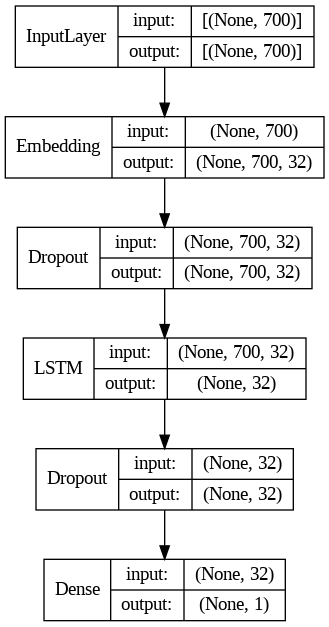

In [6]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

#Train the LSTM

In [7]:
# Train the LSTM on the training data
history = model.fit(

    # Training data : characteristics (reviews) and classes (positive or negative)    
    x_train, y_train,
                    
    # Number of examples to examine before updating the weights in the
    # backpropagation. The larger the batch size, the more memory
    # we will need
    batch_size=256, 

    # An epoch makes as many batches as it takes to exhaust the set
    # of training
    epochs=3, 
    
    # This fraction of the data will be used as the validation set, with
    # views to stop the algorithm if overlearning is occurring
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/3
79/79 [==============================] - 33s 331ms/step - loss: 0.6268 - accuracy: 0.6666 - val_loss: 0.4441 - val_accuracy: 0.8240
Epoch 2/3
79/79 [==============================] - 18s 233ms/step - loss: 0.3604 - accuracy: 0.8534 - val_loss: 0.3399 - val_accuracy: 0.8606
Epoch 3/3
79/79 [==============================] - 15s 184ms/step - loss: 0.2442 - accuracy: 0.9079 - val_loss: 0.3076 - val_accuracy: 0.8814


#Evaluate the model with the test data and see the result

In [8]:
# Get the predictions for the test data
from sklearn.metrics import classification_report
predicted_probabilities = model.predict(x_test)
predicted_classes = predicted_probabilities  > 0.5
print(classification_report(y_test, predicted_classes, target_names=class_names))
tf.math.confusion_matrix(y_test, predicted_classes)

782/782 [==============================] - 8s 10ms/step
              precision    recall  f1-score   support

    Negative       0.85      0.91      0.88     12500
    Positive       0.90      0.84      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.88      0.87      0.87     25000
weighted avg       0.88      0.87      0.87     25000



<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[11369,  1131],
       [ 2014, 10486]], dtype=int32)>

#See some wrong predictions
Let's take a look at some of the misclassified reviews. We will remove the `padding`.

In [9]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped!=y_test)[0]

# We are going to focus on the first 20 incorrect revisions
for j, incorrect in enumerate(incorrect[0:20]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect].astype(int)]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified test review ["+ str(j+1) +"]") 
    print("proof review #" + str(incorrect)  + ": foretold ["+ predicted + "] Aim ["+ actual + "]")
    print("Review text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified test review [1]
proof review #8: foretold [Positive] Aim [Negative]
Review text: <START> hollywood had a long love affair with bogus <UNKNOWN> nights tales but few of these products have stood the test of time the most memorable were the jon hall maria <UNKNOWN> films which have long since become camp this one is filled with dubbed songs <UNKNOWN> <UNKNOWN> and slapstick it's a truly crop of corn and pretty near <UNKNOWN> today it was nominated for its imaginative special effects which are almost <UNKNOWN> in this day and age <UNKNOWN> mainly of trick photography the only outstanding positive feature which survives is its beautiful color and clarity sad to say of the many films made in this genre few of them come up to alexander <UNKNOWN> original thief of <UNKNOWN> almost any other <UNKNOWN> nights film is superior to this one though it's a loser

Incorrectly classified test review [2]
proof review #17: foretold [Positive] Aim [Negative]
Review text: <START> ed 

#Test your own text as a test set
This is a fun way to check the limits of the model we have trained. You must type in all lowercase and do not use punctuation marks.

You will be able to check the prediction of the model, a value between 0 and 1

In [10]:
# Write your own review
#review = "this was a terrible film with too much sex and violence i walked out halfway through"
review = "this is the best film i have ever seen it is great and fantastic and i loved it"
#review = "this was an awful film that i will never see again"
#review = "absolutely wonderful movie i am sure i will repeat it really worth the money i am delighted with the actors and i think it is epic the best movie from this director it is really fantastic and super"

# We encode the revision (we replace the words by the integers)
tmp = []
for word in review.split(" "):
    tmp.append(word_index[word])

# We make sure that the sequence length is 500
tmp_padded = sequence.pad_sequences([tmp], maxlen=review_length) 

# We introduce the revision already processed in the model
rawprediction = model.predict(array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# We test the model and see the results
print("Revisión: " + review)
print("Predicción numérica: " + str(rawprediction))
print("Clase predicha: " + class_names[prediction])

1/1 [==============================] - 0s 24ms/step
Revisión: this is the best film i have ever seen it is great and fantastic and i loved it
Predicción numérica: 0.9666976
Clase predicha: Positive


#GRU networks
Now we are going to repeat the training but with the GRU networks. Remember that Gated Recurrent Unit (GRU) networks implement a simplification of the LSTM neuron based on reducing the number of gates, parameters and states of the same.

In [11]:
# empty stack
model = tf.keras.models.Sequential()

# Embedding
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # vocabulary size
        output_dim = 32, # Dimensionality of the embedding
        input_length = review_length # Length of input sequences
    )
)

# First Dropout
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly zero 25% of the neurons
    )
)

# GRU Layer
model.add(
    tf.keras.layers.GRU(
        units=32 # The layer will have 32 LSTM type neurons
    )
)

# Second Dropout
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly zero 25% of the neurons
    )
)

# Final dense coat
model.add(
    tf.keras.layers.Dense(
        units=1, # A single output
        activation='sigmoid' # Sigmoid activation function
    )
)

# compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # cross entropy
    optimizer=tf.keras.optimizers.Adam(), # Adam Optimizer
    metrics=['accuracy']) # Report metrics

# Display a summary of the model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 700, 32)           320000    
                                                                 
 dropout_2 (Dropout)         (None, 700, 32)           0         
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326,369
Trainable params: 326,369
Non-trainable params: 0
_________________________________________________________________


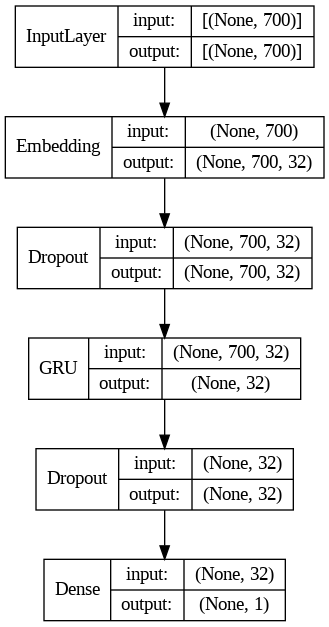

In [12]:
# render the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [13]:
# Train the GRU on the data
history = model.fit(

    # training data
    x_train, y_train,
                    
    # batch size
    batch_size=256, 

    # Number of epochs
    epochs=3, 
    
    # Validation percentage
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/3
79/79 [==============================] - 18s 205ms/step - loss: 0.6490 - accuracy: 0.6209 - val_loss: 0.4571 - val_accuracy: 0.7858
Epoch 2/3
79/79 [==============================] - 13s 158ms/step - loss: 0.3503 - accuracy: 0.8514 - val_loss: 0.3887 - val_accuracy: 0.8346
Epoch 3/3
79/79 [==============================] - 13s 162ms/step - loss: 0.2396 - accuracy: 0.9078 - val_loss: 0.3161 - val_accuracy: 0.8616


In [14]:
# Get the predictions for the test data
from sklearn.metrics import classification_report

predicted_probabilities = model.predict(x_test)
predicted_classes = predicted_probabilities  > 0.5
print(classification_report(y_test, predicted_classes, target_names=class_names))
tf.math.confusion_matrix(y_test, predicted_classes)

782/782 [==============================] - 11s 14ms/step
              precision    recall  f1-score   support

    Negative       0.85      0.88      0.87     12500
    Positive       0.88      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[10992,  1508],
       [ 1917, 10583]], dtype=int32)>

✅

Let's make our model

In [15]:
from sklearn.metrics import classification_report

In [22]:
model = tf.keras.models.Sequential()

# Increase the output_dim in the Embedding layer
model.add(
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=256,  # Increase the dimensionality
        input_length=review_length
    )
)

model.add(tf.keras.layers.Dropout(rate=0.5))

# Add a 1D Convolutional layer
model.add(
    tf.keras.layers.Conv1D(
        filters=128,
        kernel_size=2,
        activation='relu',
        padding='same'
    )
)

model.add(tf.keras.layers.Dropout(rate=0.5))

# Add a Bidirectional LSTM layer with more neurons
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.1))))

# Add a GlobalMaxPooling1D layer
model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(rate=0.5))

model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 700, 256)          2560000   
                                                                 
 dropout_8 (Dropout)         (None, 700, 256)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 700, 128)          65664     
                                                                 
 dropout_9 (Dropout)         (None, 700, 128)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 700, 256)         263168    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                     

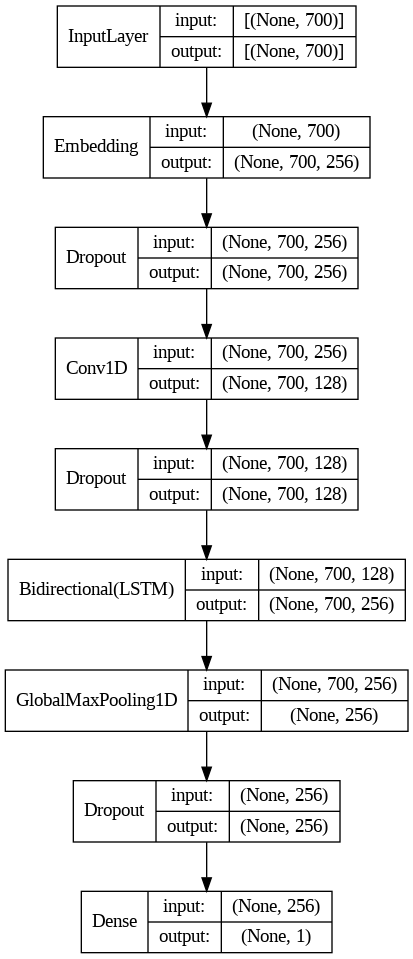

In [23]:
# render the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [24]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr / 2

# Add lr scheduler for reduction of retraining
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [25]:
# Add ModelCheckpoint for save best weights
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min',
                     save_best_only=True,verbose=1)

In [26]:
# Train
history = model.fit(

    # training data
    x_train, y_train,
                    
    # batch size
    batch_size=128, 

    shuffle=True,

    # Number of epochs
    epochs=5, 
    
    # Validation percentage
    validation_split=0.2,

    # Added callback
    callbacks=[lr_scheduler, mc],
    verbose=1
) 

Epoch 1/5
157/157 [==============================] - ETA: 0s - loss: 7.8903 - accuracy: 0.5421
Epoch 1: val_loss improved from inf to 0.57448, saving model to best_model.h5
157/157 [==============================] - 45s 251ms/step - loss: 7.8903 - accuracy: 0.5421 - val_loss: 0.5745 - val_accuracy: 0.7414 - lr: 0.0010
Epoch 2/5
157/157 [==============================] - ETA: 0s - loss: 0.4561 - accuracy: 0.8145
Epoch 2: val_loss improved from 0.57448 to 0.41751, saving model to best_model.h5
157/157 [==============================] - 37s 232ms/step - loss: 0.4561 - accuracy: 0.8145 - val_loss: 0.4175 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 3/5
157/157 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.9005
Epoch 3: val_loss improved from 0.41751 to 0.36937, saving model to best_model.h5
157/157 [==============================] - 34s 217ms/step - loss: 0.2739 - accuracy: 0.9005 - val_loss: 0.3694 - val_accuracy: 0.8596 - lr: 5.0000e-04
Epoch 4/5
157/157 [=========

In [27]:
predicted_probabilities = model.predict(x_test)
predicted_classes = predicted_probabilities  > 0.5
print(classification_report(y_test, predicted_classes, target_names=class_names))
tf.math.confusion_matrix(y_test, predicted_classes)

782/782 [==============================] - 16s 20ms/step
              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87     12500
    Positive       0.86      0.90      0.88     12500

    accuracy                           0.87     25000
   macro avg       0.88      0.87      0.87     25000
weighted avg       0.88      0.87      0.87     25000



<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[10588,  1912],
       [ 1225, 11275]], dtype=int32)>

<H1>Model with softmax</H1>

In [28]:
from keras.utils import to_categorical

In [29]:
model = tf.keras.models.Sequential()

# Increase the output_dim in the Embedding layer
model.add(
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=256,  # Increase the dimensionality
        input_length=review_length
    )
)

model.add(tf.keras.layers.BatchNormalization())

# Add a 1D Convolutional layer
model.add(
    tf.keras.layers.Conv1D(
        filters=128,
        kernel_size=10,
        activation='relu',
        padding='same'
    )
)

model.add(tf.keras.layers.Dropout(rate=0.5))

# Add a Bidirectional LSTM layer with more neurons
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.1))))

# Add a GlobalMaxPooling1D layer
model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 700, 256)          2560000   
                                                                 
 batch_normalization (BatchN  (None, 700, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_3 (Conv1D)           (None, 700, 128)          327808    
                                                                 
 dropout_11 (Dropout)        (None, 700, 128)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 700, 256)         263168    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)             

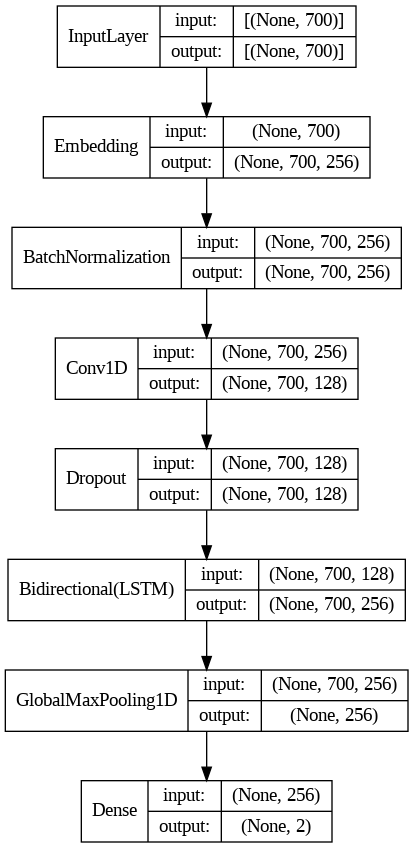

In [30]:
# render the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [31]:
# Train
history = model.fit(

    # training data
    x_train, to_categorical(y_train),
                    
    # batch size
    batch_size=128, 

    shuffle=True,

    # Number of epochs
    epochs=5, 
    
    # Validation percentage
    validation_split=0.2,

    # Added callback
    callbacks=[lr_scheduler, mc],
    verbose=1
) 

Epoch 1/5
157/157 [==============================] - ETA: 0s - loss: 15.0886 - accuracy: 0.6463
Epoch 1: val_loss did not improve from 0.36937
157/157 [==============================] - 49s 276ms/step - loss: 15.0886 - accuracy: 0.6463 - val_loss: 2.9138 - val_accuracy: 0.7036 - lr: 5.0000e-04
Epoch 2/5
157/157 [==============================] - ETA: 0s - loss: 0.9870 - accuracy: 0.8845
Epoch 2: val_loss did not improve from 0.36937
157/157 [==============================] - 37s 238ms/step - loss: 0.9870 - accuracy: 0.8845 - val_loss: 0.4790 - val_accuracy: 0.8596 - lr: 5.0000e-04
Epoch 3/5
157/157 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9342
Epoch 3: val_loss improved from 0.36937 to 0.35068, saving model to best_model.h5
157/157 [==============================] - 35s 222ms/step - loss: 0.2411 - accuracy: 0.9342 - val_loss: 0.3507 - val_accuracy: 0.8588 - lr: 2.5000e-04
Epoch 4/5
157/157 [==============================] - ETA: 0s - loss: 0.1665 - accura

In [32]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred , target_names=class_names))
tf.math.confusion_matrix(y_test, y_pred )

782/782 [==============================] - 17s 22ms/step
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89     12500
    Positive       0.91      0.86      0.88     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[11412,  1088],
       [ 1733, 10767]], dtype=int32)>